<a href="https://colab.research.google.com/github/hy2632/SystematicTrading/blob/main/TradingRules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

from pandas_datareader import data
import matplotlib.pyplot as plt
import pdb
from tqdm.notebook import tqdm
%cd drive/MyDrive/SystematicTrading/

/content/drive/MyDrive/SystematicTrading


## Some plotting methods from previous work

In [2]:
def plot_Stock_Price(start_date, end_date, *stock_names, figsize=(12,8)):
    df = [data.get_data_yahoo(stock_name, start_date, end_date) for stock_name in stock_names]
    fig, ax1 = plt.subplots(figsize = figsize)

    # ax1.set_title(f"{stock_name} {start_date} - {end_date}", fontdict={"size":20})
    ax1.set_xlabel("date")
    ax1.xaxis.grid(True, which="major", color='gray', linestyle="--", alpha=0.25)
    

    ax1.set_ylabel("$ Close")
    ax1.yaxis.grid(True, which="major", color='gray', linestyle="--", alpha=0.25)

    maxClose = [np.max(stock["Close"]) for stock in df]
    globalMaxClose = np.max(maxClose)
    # Get the order of magnitude of maximum of $Close
    magnitude = np.floor(np.log10(globalMaxClose))
    ax1.set_ylim(bottom=0, top = np.ceil(globalMaxClose/10**(magnitude))*10**(magnitude))
    
    for stock in df:
        ax1.plot(stock.index, stock["Close"])
    
    ax1.legend(stock_names)

    plt.show()

def trade(stockname: str, start_date: str, end_date: str, investmentValue: int):
    df = data.get_data_yahoo(stockname, start_date, end_date)
    plot_Stock_Price(start_date, end_date, stockname)

    out = df.iloc[-1]["Close"]/df.iloc[0]["Close"] * investmentValue
    print(f"Investment: {investmentValue}\n")
    print(f"Return: {out}\n")
    gain = out - investmentValue
    print(f"Gain: {gain}\n")

    days = (df.index[-1] - df.index[0]).days
    annualRateOfReturn = ((gain / investmentValue)**(1/days) - 1)*365
    print(f"Annual rate of return: {annualRateOfReturn}\n" )


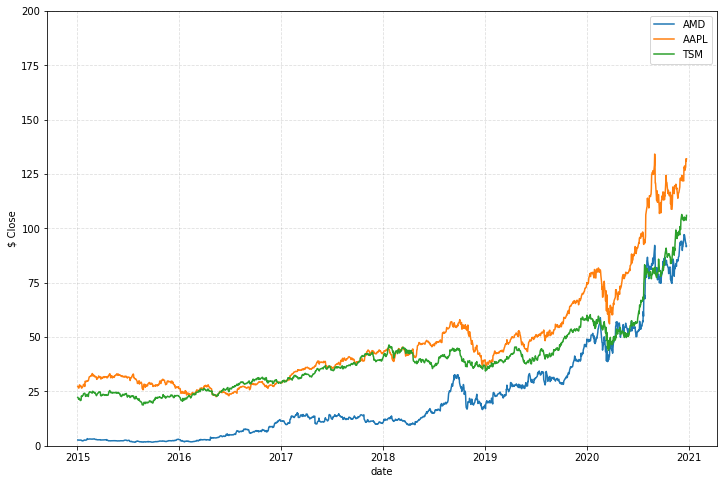

In [3]:
plot_Stock_Price("20150101", "20201225", "AMD", "AAPL", "TSM")

## Realtime stock price API

In [4]:
pip install polygon-api-client

     |████████████████████████████████| 204kB 20.0MB/s 
     |████████████████████████████████| 81kB 6.9MB/s 


In [5]:
from polygon import RESTClient


def main():
    key = "L392kWNlMUJNJB6cppuWDOZGbhtdUarX"

    # RESTClient can be used as a context manager to facilitate closing the underlying http session
    # https://requests.readthedocs.io/en/master/user/advanced/#session-objects
    with RESTClient(key) as client:
        resp = client.stocks_equities_daily_open_close("AAPL", "2018-03-02")
        print(f"On: {resp.from_} Apple opened at {resp.open} and closed at {resp.close}")


if __name__ == '__main__':
    main()

On: 2018-03-02 Apple opened at 172.8 and closed at 176.21


## Google Trends ~ Stock Price?

(P29) Some hedge funds have recently used data such as `Google search popularity` and `Twitter trending` to forecast markets.

[pytrends](https://github.com/GeneralMills/pytrends)

In [8]:
pip install pytrends

In [9]:
from pytrends.request import TrendReq
def normalize(x):
    return x / np.max(x)
def compare_price_trend(symbol="BABA", keyword="Alibaba", start_date='2020-09-01', end_date='2020-12-28'):
    pytrends = TrendReq(hl='zh-CN', tz=360)
    kw_list = [keyword]
    pytrends.build_payload(kw_list, cat=0, timeframe=start_date+' '+end_date, geo='', gprop='')
    plt.figure(figsize=(10,6))
    plt.plot(normalize(data.get_data_yahoo(symbol, start_date, end_date)["Adj Close"]))
    plt.plot(normalize(pytrends.interest_over_time()[keyword]), marker="o")
    plt.legend(["Price", "Trend"])
    plt.show()

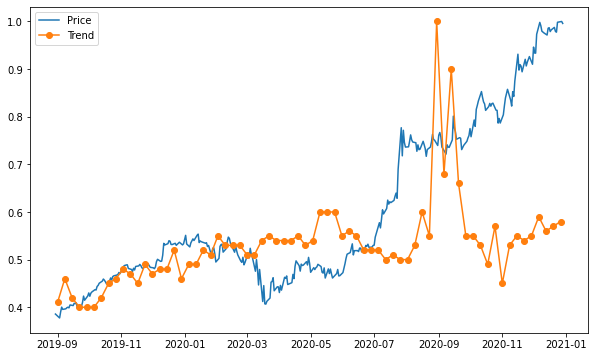

In [10]:
compare_price_trend("TSM", "NVIDIA", "2019-08-30", "2020-12-29")

## 40日均线 / 20日均线



In [51]:
def MA(symbol="BABA", lag=40):
    today = str(pd.Timestamp.now().date())
    forty_days_before = str(pd.Timestamp.now().date() - pd.to_timedelta(lag, unit="D"))
    return data.get_data_yahoo(symbol, forty_days_before, today)

In [52]:
def MA40_20(*symbol):
    print("40 days MA < 20 days MA:")
    return list(map(lambda x: MA(x, 40)["Adj Close"].mean() < MA(x, 20)["Adj Close"].mean() , symbol))

In [53]:
MA40_20(["BABA", "XOM", "AMD", "INTC", "NIO", "BA"])

40 days MA < 20 days MA:


[Symbols
 BABA    False
 XOM      True
 AMD      True
 INTC     True
 NIO     False
 BA       True
 dtype: bool]